In [1]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [2]:
import re
import json
import pprint
import numpy as np
import pandas as pd
import seaborn as sns
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from scipy.stats import mannwhitneyu
from sklearn.utils import shuffle
from textblob import TextBlob
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk import RegexpParser

from keras.preprocessing.text import text_to_word_sequence

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from wordcloud import wordcloud

## Stats for combined data

In [3]:
# Fetching all the text-target files from the folder and merging them 
path_all_text_target = '/content/drive/MyDrive/dataset_patent/text_target'
files_all_text_target = [f for f in listdir(path_all_text_target) if isfile(join(path_all_text_target, f))]
print(files_all_text_target)

['pos_text_target.csv', 'neg_text_target.csv', 'neut_text_target.csv']


In [6]:
combined_all_text_target = pd.concat([pd.read_csv(path_all_text_target+'/'+f) for f in files_all_text_target ])

In [7]:
combined_all_text_target.head()

,text,target
0,The present invention can enhance the shaping ...,1
1,"According to the present invention, a slide fa...",1
2,"According to the present invention, it is poss...",1
3,In the diagnostic medical image system accordi...,1
4,A dental implant fixture according to the pres...,1


In [8]:
# Scikit-learn shuffle 
combined_all_text_target = shuffle(combined_all_text_target, random_state=0)

In [9]:
combined_all_text_target.head()

,text,target
46700,"According to the slurry for forming a mold, th...",1
77528,"However, in the filter unit for biological com...",-1
2820,According to the tire pressure decrease detect...,1
30178,In order to solve the above conventional probl...,0
53921,A network node according to an aspect of the p...,0


In [10]:
# Reseting index such that it starts from 0,1,2, ... so on 
combined_all_text_target.reset_index(inplace=True, drop=True)

In [11]:
combined_all_text_target.head(10)

,text,target
0,"According to the slurry for forming a mold, th...",1
1,"However, in the filter unit for biological com...",-1
2,According to the tire pressure decrease detect...,1
3,In order to solve the above conventional probl...,0
4,A network node according to an aspect of the p...,0
5,"In this regard, according to the inventors of ...",-1
6,"However, such conventional art has the followi...",-1
7,An installation space for a diesel engine vari...,-1
8,The liquid-cooled jacket 300 shown in FIG. 50 ...,-1
9,"According to a wireless communication system, ...",1


In [12]:
# A copied file to play with the text-target dataset
df_analysis = combined_all_text_target.copy()

In [13]:
# Calculating total numbers of the sample 
print("Size of the data: ", combined_all_text_target.shape[0])

Size of the data:  205635


In [14]:
# Checking counts of respective labels 
combined_all_text_target['target'].value_counts()

-1    89105
 0    63055
 1    53475
Name: target, dtype: int64

In [15]:
df_analysis['text'] = df_analysis['text'].apply(str)

In [16]:
# Tokenization using NLTK  - Taking 5 minutes on colab 


# df_analysis['tokenized_sents'] = df_analysis.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)

In [17]:
# Tokenization using keras - Takind 1 minutes on colab
df_analysis['keras_tokenized_sents'] = df_analysis.apply(lambda row: text_to_word_sequence(row['text']), axis=1)

In [18]:
df_analysis.head()

,text,target,keras_tokenized_sents
0,"According to the slurry for forming a mold, th...",1,"[according, to, the, slurry, for, forming, a, ..."
1,"However, in the filter unit for biological com...",-1,"[however, in, the, filter, unit, for, biologic..."
2,According to the tire pressure decrease detect...,1,"[according, to, the, tire, pressure, decrease,..."
3,In order to solve the above conventional probl...,0,"[in, order, to, solve, the, above, conventiona..."
4,A network node according to an aspect of the p...,0,"[a, network, node, according, to, an, aspect, ..."


Let's see how both tokenization works

In [19]:
# nltk tokenization 

# print(df_analysis['tokenized_sents'][0])

In [20]:
# Keras tokenization 
print(df_analysis['keras_tokenized_sents'][0])

['according', 'to', 'the', 'slurry', 'for', 'forming', 'a', 'mold', 'the', 'mold', 'and', 'the', 'method', 'for', 'producing', 'a', 'mold', 'a', 'casting', 'can', 'be', 'stably', 'molded', 'and', 'the', 'mold', 'can', 'easily', 'collapse', 'in', 'on', 'itself']


It seems like the tokenization perform better considering following factors 


1.   Execution time is better (As seen above in code)
2.   Converting all tokens in lower case
3.   It is not considering punctuation as new token  



In [21]:
df_analysis['total_words_k_token'] = df_analysis['keras_tokenized_sents'].apply(lambda x : len(x))

In [22]:
df_analysis.head()

,text,target,keras_tokenized_sents,total_words_k_token
0,"According to the slurry for forming a mold, th...",1,"[according, to, the, slurry, for, forming, a, ...",32
1,"However, in the filter unit for biological com...",-1,"[however, in, the, filter, unit, for, biologic...",192
2,According to the tire pressure decrease detect...,1,"[according, to, the, tire, pressure, decrease,...",38
3,In order to solve the above conventional probl...,0,"[in, order, to, solve, the, above, conventiona...",1535
4,A network node according to an aspect of the p...,0,"[a, network, node, according, to, an, aspect, ...",319


In [23]:
# Total number of words in text - overall
print('Total number of words ' + str(df_analysis['total_words_k_token'].sum()))

Total number of words 61075453


In [24]:
# Highest number of words in text 
print('Highest number of words in text is : ' + str(df_analysis['total_words_k_token'].max()))

# Lowest number of words in text 
print('Lowest number of words in text is : ' + str(df_analysis['total_words_k_token'].min()))

# Average number of words in text 
print('Average number of words in text is : ' + str(df_analysis['total_words_k_token'].mean()))

Highest number of words in text is : 7317
Lowest number of words in text is : 0
Average number of words in text is : 297.0090354268485


In [25]:
# Checking the rows having lowest number of words = 0
df_analysis[df_analysis['total_words_k_token']==0]

,text,target,keras_tokenized_sents,total_words_k_token
131642,-,1,[],0


Depending on usage we would like to remove such rows 

In [27]:
# Saving a generated file on drive = Having size of 1.41GB
# df_analysis.to_csv( "/content/drive/MyDrive/dataset_patent/generated_files/df_analysis.csv", index=False, encoding='utf-8-sig')

In [28]:
# df_analysis = pd.read_csv('/content/drive/MyDrive/dataset_patent/generated_files/df_analysis.csv')

In [29]:
df_analysis.head()

,text,target,keras_tokenized_sents,total_words_k_token
0,"According to the slurry for forming a mold, th...",1,"[according, to, the, slurry, for, forming, a, ...",32
1,"However, in the filter unit for biological com...",-1,"[however, in, the, filter, unit, for, biologic...",192
2,According to the tire pressure decrease detect...,1,"[according, to, the, tire, pressure, decrease,...",38
3,In order to solve the above conventional probl...,0,"[in, order, to, solve, the, above, conventiona...",1535
4,A network node according to an aspect of the p...,0,"[a, network, node, according, to, an, aspect, ...",319


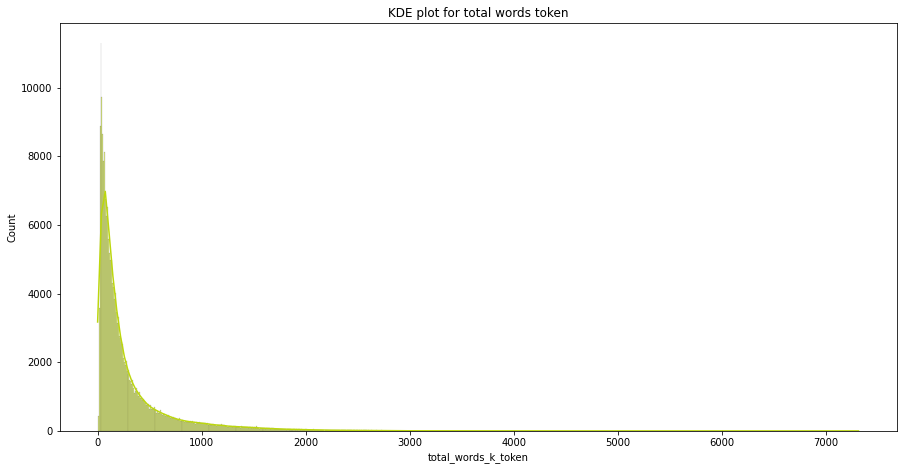

In [30]:
fig, ax = plt.subplots(figsize=(15, 7.5))
sns.histplot(df_analysis.total_words_k_token, kde=True, ax=ax, color='#BCD70E')
plt.title('KDE plot for total words token')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



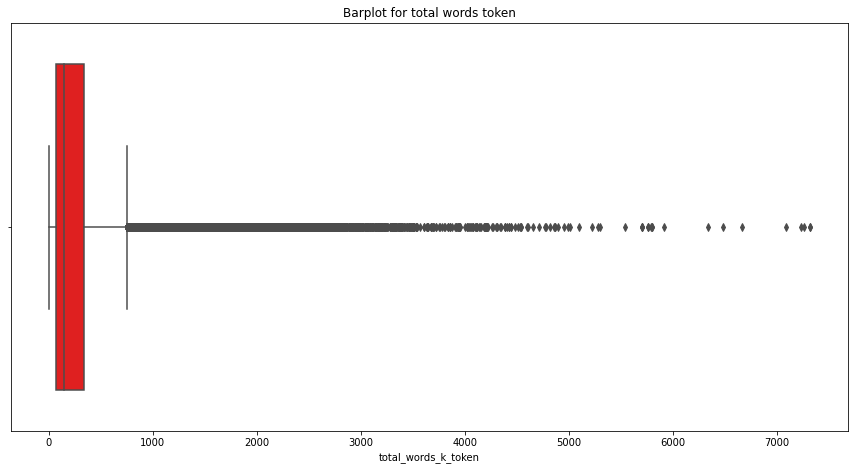

In [31]:
fig, ax = plt.subplots(figsize=(15, 7.5))
sns.boxplot(df_analysis.total_words_k_token, ax=ax, color='#ff0000')
plt.title('Barplot for total words token')
plt.show()

In [32]:
text = '''
The titular threat of The Blob has always struck me as the ultimate movie
monster: an insatiably hungry, amoeba-like mass able to penetrate
virtually any safeguard, capable of--as a doomed doctor chillingly
describes it--"assimilating flesh on contact.
Snide comparisons to gelatin be damned, it's a concept with the most
devastating of potential consequences, not unlike the grey goo scenario
proposed by technological theorists fearful of
artificial intelligence run rampant.
'''

In [33]:
blob = TextBlob(text)
b_tags = blob.tags           # [('The', 'DT'), ('titular', 'JJ'),
                    #  ('threat', 'NN'), ('of', 'IN'), ...]

b_np = blob.noun_phrases   # WordList(['titular threat', 'blob',
                    #            'ultimate movie monster',
                    #            'amoeba-like mass', ...])

for sentence in blob.sentences:
    print(sentence.sentiment.polarity)

print(b_tags)
print(b_np)    

0.06000000000000001
-0.34166666666666673
[('The', 'DT'), ('titular', 'JJ'), ('threat', 'NN'), ('of', 'IN'), ('The', 'DT'), ('Blob', 'NNP'), ('has', 'VBZ'), ('always', 'RB'), ('struck', 'VBN'), ('me', 'PRP'), ('as', 'IN'), ('the', 'DT'), ('ultimate', 'JJ'), ('movie', 'NN'), ('monster', 'NN'), ('an', 'DT'), ('insatiably', 'RB'), ('hungry', 'JJ'), ('amoeba-like', 'JJ'), ('mass', 'NN'), ('able', 'JJ'), ('to', 'TO'), ('penetrate', 'VB'), ('virtually', 'RB'), ('any', 'DT'), ('safeguard', 'NN'), ('capable', 'JJ'), ('of', 'IN'), ('as', 'IN'), ('a', 'DT'), ('doomed', 'JJ'), ('doctor', 'NN'), ('chillingly', 'RB'), ('describes', 'VBZ'), ('it', 'PRP'), ('assimilating', 'VBG'), ('flesh', 'NN'), ('on', 'IN'), ('contact', 'NN'), ('Snide', 'JJ'), ('comparisons', 'NNS'), ('to', 'TO'), ('gelatin', 'VB'), ('be', 'VB'), ('damned', 'VBN'), ('it', 'PRP'), ("'s", 'VBZ'), ('a', 'DT'), ('concept', 'NN'), ('with', 'IN'), ('the', 'DT'), ('most', 'RBS'), ('devastating', 'JJ'), ('of', 'IN'), ('potential', 'JJ'), (

In [34]:
text_p = df_analysis['text'][2]
print(text_p)

According to the tire pressure decrease detection device, the method, and the program of the present invention, the influence of the periodic noise can be eliminated and the estimate precision of the tire resonance frequency can be improved.


In a system disclosed in Japanese Patent Laying-Open No. 2010-035277 (PTL 1), determination of a charging mode and a power supply mode is performed based on a pilot signal transmitted from a power cable.', 'However, to improve accuracy in determination, it is preferable that two or more determination systems are provided. On this point, in a system for determining the power charging mode and the power supply mode based only on a pilot signal, there was a room for improvement in enhancing the accuracy in determination.


In [35]:
# Applying text blob extracting information 
text_p_blob = TextBlob(text_p)


In [36]:
# Extracting tags from the text 
text_p_tags = text_p_blob.tags
print(text_p_tags)

[('According', 'VBG'), ('to', 'TO'), ('the', 'DT'), ('tire', 'NN'), ('pressure', 'NN'), ('decrease', 'NN'), ('detection', 'NN'), ('device', 'NN'), ('the', 'DT'), ('method', 'NN'), ('and', 'CC'), ('the', 'DT'), ('program', 'NN'), ('of', 'IN'), ('the', 'DT'), ('present', 'JJ'), ('invention', 'NN'), ('the', 'DT'), ('influence', 'NN'), ('of', 'IN'), ('the', 'DT'), ('periodic', 'JJ'), ('noise', 'NN'), ('can', 'MD'), ('be', 'VB'), ('eliminated', 'VBN'), ('and', 'CC'), ('the', 'DT'), ('estimate', 'NN'), ('precision', 'NN'), ('of', 'IN'), ('the', 'DT'), ('tire', 'NN'), ('resonance', 'NN'), ('frequency', 'NN'), ('can', 'MD'), ('be', 'VB'), ('improved', 'VBN')]


In [37]:
text_p_phrase = text_p_blob.noun_phrases
print(text_p_phrase)

['according', 'tire pressure', 'detection device', 'present invention', 'periodic noise', 'estimate precision', 'tire resonance frequency']


In [38]:
for sentence in text_p_blob.sentences:
    print(sentence.sentiment.polarity)

0.0


## Cleaning data (considering duplicacy and null values)

In [39]:
pos_text_target = pd.read_csv('/content/drive/MyDrive/dataset_patent/text_target/pos_text_target.csv',index_col= False)
neg_text_target = pd.read_csv('/content/drive/MyDrive/dataset_patent/text_target/neg_text_target.csv',index_col= False)
neut_text_target = pd.read_csv('/content/drive/MyDrive/dataset_patent/text_target/neut_text_target.csv',index_col= False)

In [40]:
# Chcking sahpe of dataframe before preprocessing
print(pos_text_target.shape)
print(neg_text_target.shape)
print(neut_text_target.shape)

(53475, 2)
(89105, 2)
(63055, 2)


In [41]:
# Checking null values in the table
print(pos_text_target.isnull().values.any())
print(neg_text_target.isnull().values.any())
print(neut_text_target.isnull().values.any())


True
True
True


In [42]:
# Dropping null values 
pos_text_target.dropna(axis = 0, inplace=True)
neg_text_target.dropna(axis = 0, inplace=True)
neut_text_target.dropna(axis = 0, inplace=True)


In [43]:
# Checking shape of frame after dropping null values 
print(pos_text_target.shape)
print(neg_text_target.shape)
print(neut_text_target.shape)

(53444, 2)
(89030, 2)
(62958, 2)


In [44]:
# Checking wether there is duplicate values or not
pos_text_target[pos_text_target.duplicated('text')]

,text,target
180,The heat-absorbing glass plate of the present ...,1
229,The present invention can provide a surface-en...,1
406,The present invention can process data accordi...,1
464,The present invention can provide a surface-en...,1
543,"According to the above, mechanical characteris...",1
...,...,...
53462,"According to each aspect stated above, it is p...",1
53465,The communication apparatus according to the p...,1
53468,According to several aspects of the present in...,1
53469,"According to the present invention, a CIoT ter...",1


In [45]:
pos_text_target['text'][180]

'The heat-absorbing glass plate of the present invention satisfies both low solar transmittance and high visible light transmittance. Particularly, according to the present invention, it is possible to obtain a heat-absorbing glass having a ratio Tv/Te of the visible light transmittance higher than conventional glass, relative to the amount of total iron t-Fe2O3 as calculated as Fe2O3 as represented by mass % based on oxides.'

In [46]:
# Finding rows having same text data
pos_text_target[pos_text_target['text']=='The heat-absorbing glass plate of the present invention satisfies both low solar transmittance and high visible light transmittance. Particularly, according to the present invention, it is possible to obtain a heat-absorbing glass having a ratio Tv/Te of the visible light transmittance higher than conventional glass, relative to the amount of total iron t-Fe2O3 as calculated as Fe2O3 as represented by mass % based on oxides.']

,text,target
179,The heat-absorbing glass plate of the present ...,1
180,The heat-absorbing glass plate of the present ...,1


In [47]:
# Removing duplicated rows and printing shape
pos_text_target.drop_duplicates(keep='first',inplace=True)
print(pos_text_target.shape)

(48202, 2)


In [48]:
# Checking wether there is duplicate values or not
neg_text_target[neg_text_target.duplicated('text')]

,text,target
310,"However, the methods disclosed in Patent Liter...",-1
467,An aspect of the present invention provides a ...,-1
469,An object of the present invention is to provi...,-1
647,An object of the present invention is to provi...,-1
725,It is therefore an object of the present inven...,-1
...,...,...
89086,An object of the present invention is to provi...,-1
89090,The present invention has been made in effort ...,-1
89091,"However, according to the technique described ...",-1
89095,"In the LAA, when an unallocated frequency band...",-1


In [49]:
neg_text_target['text'][467]

"An aspect of the present invention provides a method and apparatus for encoding an image, which can improve image compression efficiency.', 'Another aspect of the present invention provides a method and apparatus for decoding an image, which can improve image compression efficiency.', 'Still another aspect of the present invention provides a method and apparatus for inter prediction, which can improve image compression efficiency.', 'Still yet another aspect of the present invention provides a method and apparatus for deriving a temporal motion vector predictor, which can improve image compression efficiency."

In [50]:
# Finding rows having same text data
neg_text_target[neg_text_target['text'] == "An aspect of the present invention provides a method and apparatus for encoding an image, which can improve image compression efficiency.', 'Another aspect of the present invention provides a method and apparatus for decoding an image, which can improve image compression efficiency.', 'Still another aspect of the present invention provides a method and apparatus for inter prediction, which can improve image compression efficiency.', 'Still yet another aspect of the present invention provides a method and apparatus for deriving a temporal motion vector predictor, which can improve image compression efficiency."]

,text,target
228,An aspect of the present invention provides a ...,-1
467,An aspect of the present invention provides a ...,-1
88758,An aspect of the present invention provides a ...,-1


In [51]:
# Removing duplicated rows 
neg_text_target.drop_duplicates(keep='first',inplace=True)
print(neg_text_target.shape)

(79531, 2)


In [52]:
neut_text_target[neut_text_target.duplicated('text')]

,text,target
239,In order to solve the above-described problems...,0
755,The present inventors have conducted diligent ...,0
819,A transmission device of the present invention...,0
877,A fan according to an aspect of the present in...,0
1206,In the case with a grommet with its cylindrica...,0
...,...,...
63037,According to a first aspect of the present inv...,0
63040,"In a first aspect, a radio terminal that is us...",0
63041,Embodiments of the present disclosure provide ...,0
63044,In order to solve the above-described problems...,0


In [53]:
neut_text_target['text'][239]

"In order to solve the above-described problems, a method of producing a composite reinforcing material of the present invention comprises a step of kneading at least a graphite-based carbon material and a reinforcing material into a base material,', 'the graphite-based carbon material having a rhombohedral graphite layer (3R) and a hexagonal graphite layer (2H), wherein a Rate (3R) of the rhombohedral graphite layer (3R) and the hexagonal graphite layer (2H), based on an X-ray diffraction method, which is defined by following Equation 1 is 31% or more:"

In [54]:
neut_text_target[neut_text_target['text']=="In order to solve the above-described problems, a method of producing a composite reinforcing material of the present invention comprises a step of kneading at least a graphite-based carbon material and a reinforcing material into a base material,', 'the graphite-based carbon material having a rhombohedral graphite layer (3R) and a hexagonal graphite layer (2H), wherein a Rate (3R) of the rhombohedral graphite layer (3R) and the hexagonal graphite layer (2H), based on an X-ray diffraction method, which is defined by following Equation 1 is 31% or more:"]

,text,target
238,In order to solve the above-described problems...,0
239,In order to solve the above-described problems...,0
59911,In order to solve the above-described problems...,0


In [55]:
# Removing duplicated rows 
neut_text_target.drop_duplicates(keep='first',inplace=True)
print(neut_text_target.shape)

(58043, 2)


In [56]:
# Shape of frame after dropping values  

print(pos_text_target.shape)
print(neg_text_target.shape)
print(neut_text_target.shape)

(48202, 2)
(79531, 2)
(58043, 2)


In [57]:
# Tokenization using keras - Takind 1 minutes on colab
pos_text_target['keras_tokenized_sents'] = pos_text_target.apply(lambda row: text_to_word_sequence(row['text']), axis=1)
neg_text_target['keras_tokenized_sents'] = neg_text_target.apply(lambda row: text_to_word_sequence(row['text']), axis=1)
neut_text_target['keras_tokenized_sents'] = neut_text_target.apply(lambda row: text_to_word_sequence(row['text']), axis=1)


In [58]:
# Counting total words per text in dataframe 
pos_text_target['total_words_k_token'] = pos_text_target['keras_tokenized_sents'].apply(lambda x : len(x))
neg_text_target['total_words_k_token'] = neg_text_target['keras_tokenized_sents'].apply(lambda x : len(x))
neut_text_target['total_words_k_token'] = neut_text_target['keras_tokenized_sents'].apply(lambda x : len(x))


In [59]:
pos_text_target['total_words_k_token'].describe()

count    48202.00000
mean       120.93353
std        201.55039
min          0.00000
25%         35.00000
50%         61.00000
75%        120.00000
max       3929.00000
Name: total_words_k_token, dtype: float64

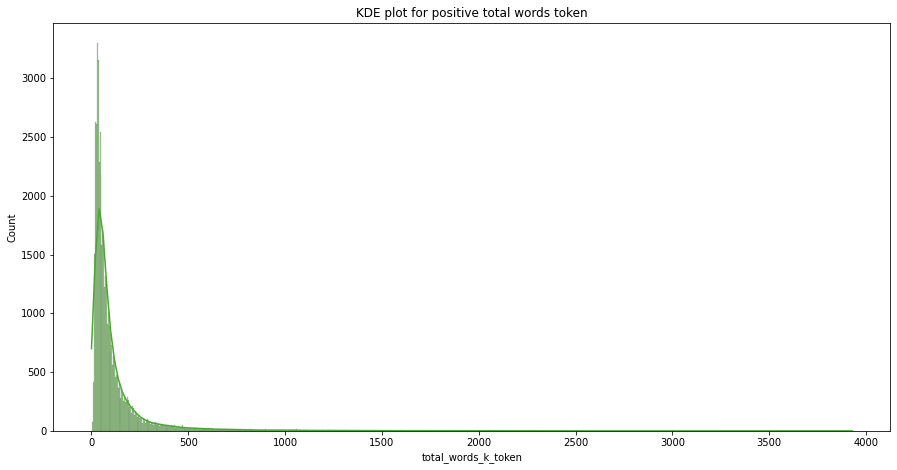

In [60]:
fig, ax = plt.subplots(figsize=(15, 7.5))
sns.histplot(pos_text_target.total_words_k_token, kde=True, ax=ax, color='#48a832')
plt.title('KDE plot for positive total words token')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



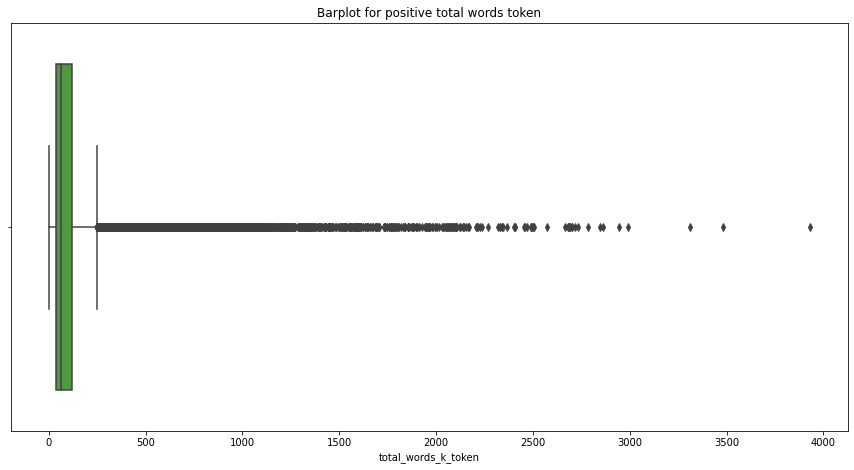

In [61]:
fig, ax = plt.subplots(figsize=(15, 7.5))
sns.boxplot(pos_text_target.total_words_k_token, ax=ax, color='#48a832')
plt.title('Barplot for positive total words token')
plt.show()

In [62]:
# Counting total numbers of text having tokens greater than 500
pos_text_target[pos_text_target['total_words_k_token'] > 500].count()  

text                     1832
target                   1832
keras_tokenized_sents    1832
total_words_k_token      1832
dtype: int64

In [63]:
neg_text_target['total_words_k_token'].describe()


count    79531.000000
mean       198.100288
std        207.966357
min          6.000000
25%         75.000000
50%        138.000000
75%        244.000000
max       4781.000000
Name: total_words_k_token, dtype: float64

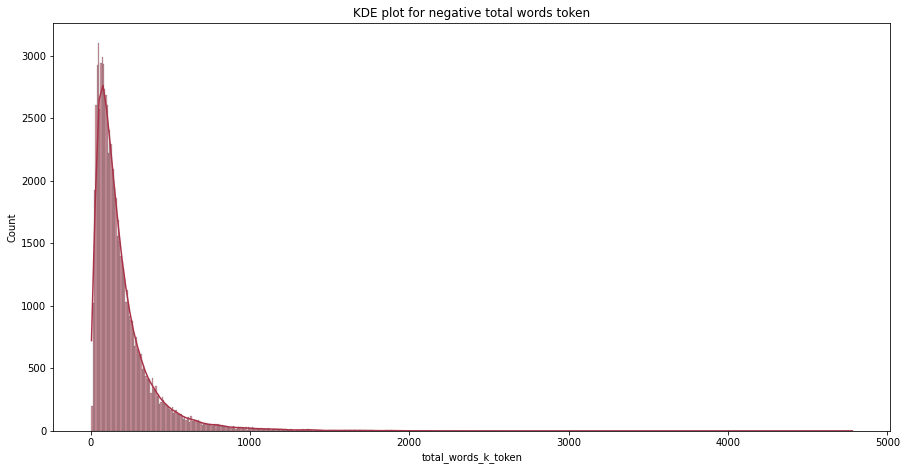

In [64]:
fig, ax = plt.subplots(figsize=(15, 7.5))
sns.histplot(neg_text_target.total_words_k_token, kde=True, ax=ax, color='#a83248')
plt.title('KDE plot for negative total words token')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



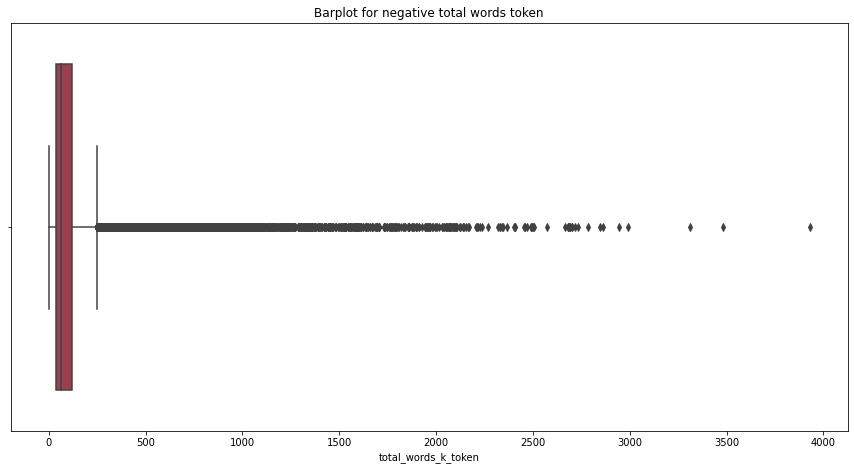

In [65]:
fig, ax = plt.subplots(figsize=(15, 7.5))
sns.boxplot(pos_text_target.total_words_k_token, ax=ax, color='#a83248')
plt.title('Barplot for negative total words token')
plt.show()

In [66]:
# Counting total numbers of text having tokens greater than 500
neg_text_target[neg_text_target['total_words_k_token'] > 500].count()  

text                     5216
target                   5216
keras_tokenized_sents    5216
total_words_k_token      5216
dtype: int64

In [67]:
neut_text_target['total_words_k_token'].describe()


count    58043.000000
mean       593.475682
std        564.331262
min          2.000000
25%        193.000000
50%        410.000000
75%        819.000000
max       7317.000000
Name: total_words_k_token, dtype: float64

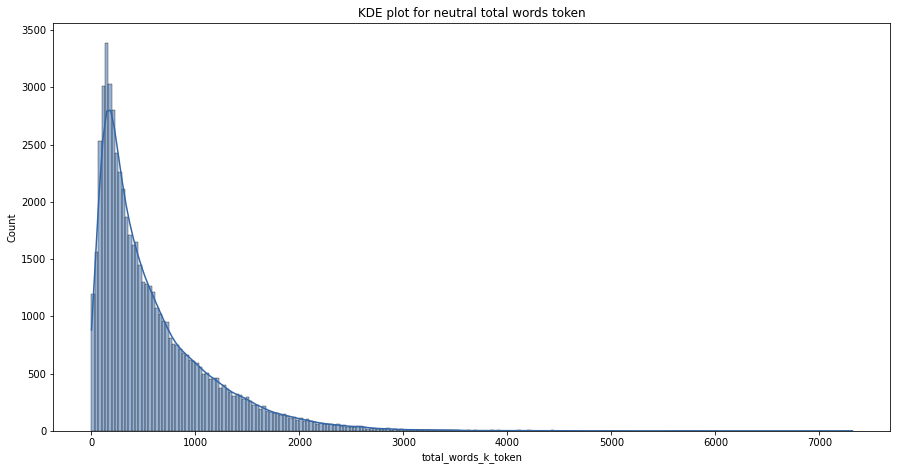

In [68]:
fig, ax = plt.subplots(figsize=(15, 7.5))
sns.histplot(neut_text_target.total_words_k_token, kde=True, ax=ax, color='#3266a8')
plt.title('KDE plot for neutral total words token')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



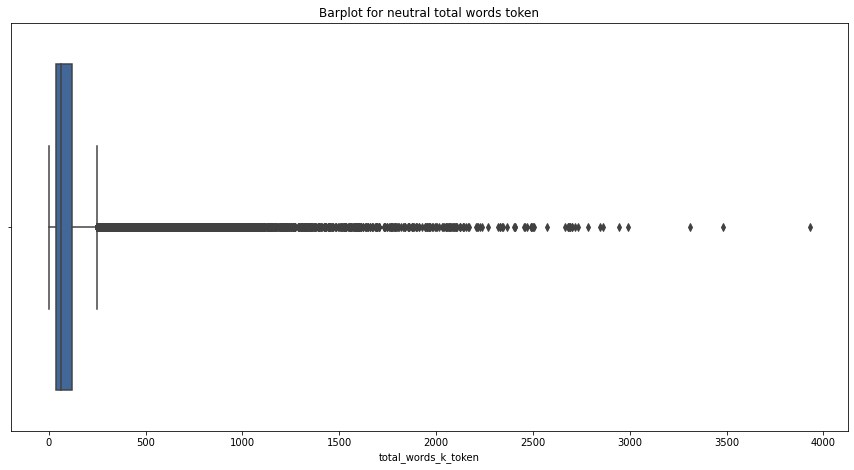

In [69]:
fig, ax = plt.subplots(figsize=(15, 7.5))
sns.boxplot(pos_text_target.total_words_k_token, ax=ax, color='#3266a8')
plt.title('Barplot for neutral total words token')
plt.show()

In [70]:
# Counting total numbers of text having tokens greater than 500
neut_text_target[neut_text_target['total_words_k_token'] > 500].count()  

text                     24763
target                   24763
keras_tokenized_sents    24763
total_words_k_token      24763
dtype: int64